# Mini-Lab 2

**Due**: Monday November 10th

Getting setup for deep learning. This lab will assume the Python library JAX. However, if you use some other package (e.g., PyTorch) or language (e.g., Julia), that's OK too. In that case, still follow the steps below, but using your setup.

# Part I: Computing environment on a cluster

Deep learning requires using a computer other than your laptop. This first part will get you setup for using JAX on Unity. 

If you are using another computing cluster or a non-JAX deep learning framework, please also do this setup step, but for your choice.

1. Follow these steps on how to get setup on Unity: https://github.com/sfield17/MTH602-Fall2025-SciML/blob/main/README.md#deep-learning-environment-setups
2. After completing this step, launch a Jupyter lab instance, select the appropriate kernel (mth602-jax-env if you are following the URL from above) and then run the following code in your notebook. You can match Scott's output

**Scott's output**: 
```bash
JAX platform: cpu
jax_enable_x64 = True
Python: 3.11.14
NumPy: 2.3.4
Optax: 0.2.6
```

**Python Code**: 
```python
import os, sys
import numpy as np

import jax
import jax.numpy as jnp

import importlib

jax.config.update('jax_enable_x64', True)

jax_platform = jax.devices()[0].platform
print("JAX platform:", jax_platform)
print("jax_enable_x64 =", jnp.ones(1).dtype == jnp.float64)

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Optax:", importlib.import_module('optax').__version__)
````

In [1]:
# here we can see what machine you are running on 
# please run this notebook on Unity, colab, or any other resource you have access too
# Do not run on a personal laptop or desktop
!hostname

umd-cscdr-cpu016


# Part II: Getting started with JAX

Here you will optimize a 2D function with Jax. You will learn about JAX arrays, JAX's just-in-time compiler (jit), how to compute gradients, how to use an Optax optimizer, and plotting the optimizer's path.

the function you will optimize is $f(x,y) = x^2 + y^2$


In [2]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# regular python function for f(x,y) 
def f(w):
    x, y = w
    return x**2 + y**2

In [4]:
# JAX magic: 
#   1. f_val_and_grad is a collection of 
#      two function for the value and gradient
#   2. JIT-compiled for speed
f_val_and_grad = jax.jit(jax.value_and_grad(f))

In [5]:
# lets see how to use f_val_and_grad 
# Notice we need to pass a JAX version of a numpy array
w = jnp.array([0.0, 0.0])
f_value, f_grad = f_val_and_grad(w)

# value of f at w
print(f_value)

# gradient of f at w
print(f_grad)

0.0
[0. 0.]


In [6]:
# we will use the stochastic gradient descent optimizer with
# a fixed learning rate
optim = optax.sgd(1e-2)

In [7]:
# Functions that define one epoch/step of a training loop 
@jax.jit
def one_step(opt_state, w):
    val, g = f_val_and_grad(w)
    updates, opt_state = optim.update(g, opt_state, w)
    w = optax.apply_updates(w, updates)
    return opt_state, w, val

# full training -- specify initial value of parameters and number of epochs
def train_model(w0=jnp.array([2.5, -2.0]), steps=200):
    opt_state = optim.init(w0)
    ws = [np.array(w0)]
    vals = []
    w = w0
    for k in range(steps):
        opt_state, w, val = one_step(opt_state, w)
        vals.append(val)
        ws.append(np.array(w))
    return np.array(ws), np.array(vals)

In [8]:
ws, vals = train_model(steps=200)

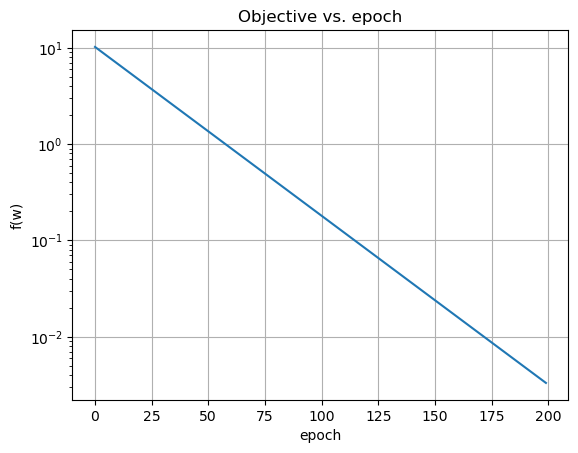

In [9]:
# loss function vs epoch
plt.semilogy(vals)
plt.xlabel("epoch")
plt.ylabel("f(w)")
plt.title("Objective vs. epoch")
plt.grid(True)

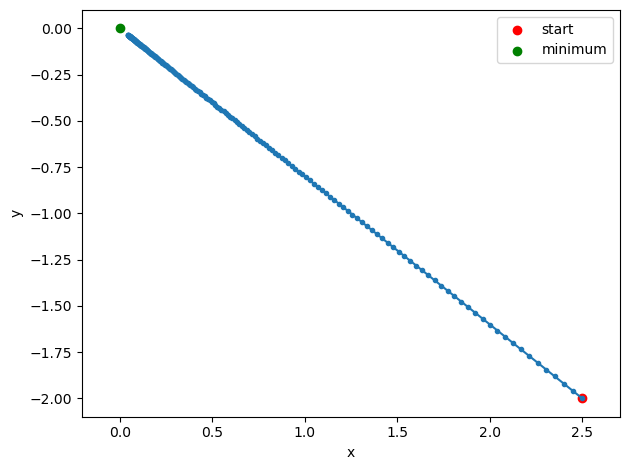

In [10]:
plt.figure()
plt.plot(ws[:,0], ws[:,1], marker="o", ms=3)
plt.scatter([ws[0,0]],[ws[0,1]], c="red", label="start")
plt.scatter([0],[0], c="green", label="minimum")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal"); 
plt.tight_layout()
plt.show()

# PART III: linear regression with JAX

This example does linear regression y(x) = a + b x 

its a very simple case: (i) the entire training set is used (no batches), and (ii) the gradient descent algorithm is done "by hand"


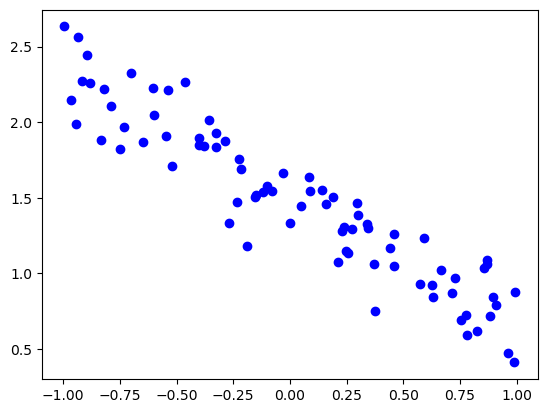

In [11]:
# create training data with numpy, then convert to JAX
rng = np.random.default_rng(0)

# generate dataset
data_size = 80
a_true    = 1.5
b_true    = -0.8
x_np      = rng.uniform(-1.0, 1.0, size=data_size)
y_np      = a_true + b_true * x_np + 0.2 * rng.normal(size=data_size)


x = jnp.array(x_np)
y = jnp.array(y_np)

# JAX arrays can be directly plotted
plt.plot(x,y,'bo')

In [12]:
# define the model
def model(theta, x):
    return theta[0] + theta[1] * x

# mse will be our loss function
# notice the model is called here
def mse(theta, x, y):
    r = model(theta, x) - y
    return jnp.mean(r * r)

# the optimzer needs the JAX-ified gradient of the mse
value_and_grad = jax.jit(jax.value_and_grad(mse))

In [29]:
# by-hand gradient descent... theta --->  theta - lr * grad

# set the learning rate
lr = 2e-2

# initial guess for the model weights
theta = jnp.array([0.0, 0.0])

losses = []
for _ in range(2000): # loop over epochs
    val, g = value_and_grad(theta, x, y) # compute loss and gradient
    theta = theta - lr * g  # SGD update
    losses.append(val)  # log loss

losses = np.array(losses)
print(f"Learned (a, b] = {theta[0]}, {theta[1]}")

Learned (a, b] = 1.4985424280166626, -0.8379092216491699


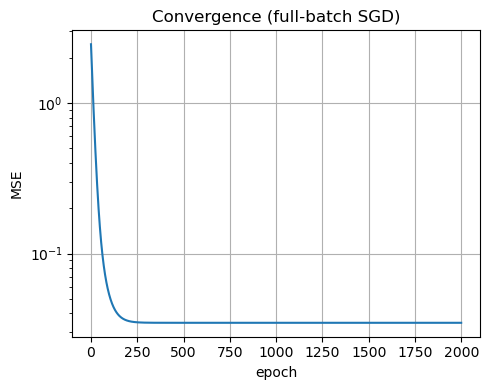

In [30]:
plt.figure(figsize=(5,4))
plt.semilogy(losses)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Convergence (full-batch SGD)")
plt.grid(True); plt.tight_layout()
plt.show()

Learned (a, b) = (1.5085, -0.8454)


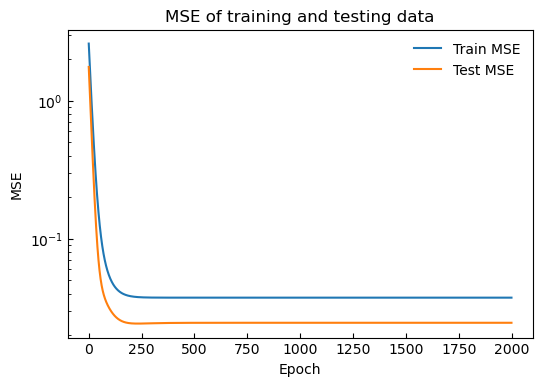

In [34]:
# YOUR WORK HERE -- write code that reruns the training example we just did
# But now plot the MSE over a training and testing set of data.

# 80-20 split
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test,  y_test  = x[split:], y[split:]

# parameters
theta = jnp.array([0.0, 0.0])
lr = 2e-2
n_epochs = 2000

# losses
train_loss = []
test_loss = []

# mse computation
for _ in range(n_epochs):
    val_train, grad = value_and_grad(theta, x_train, y_train)
    theta = theta - lr * grad
    val_test = mse(theta, x_test, y_test)
    train_loss.append(float(val_train))
    test_loss.append(float(val_test))

# weights
print(f"Learned (a, b) = ({theta[0]:.4f}, {theta[1]:.4f})")

# plot
plt.figure(figsize=(6, 4))
plt.semilogy(train_loss, label="Train MSE")
plt.semilogy(test_loss,  label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(frameon=False)
plt.tick_params(axis="both", which="both", direction="in")
plt.title("MSE of training and testing data")
plt.show()

# DONE!

Submit this lab by showing scott. Two things need to be demonstrated:

1. You ran the notebook on a machine thats not your own (e.g. on Unity)
2. Show the very last part plot thats requested -- the MSE vs epoch over a training and testing dataset.


If you complete this after class, please upload it to your github page and email scott.